In [1]:
!pip install gdown
!pip install --upgrade datasets
!pip install tokenizers
!pip install transformers==4.46.1
!pip install torch==2.5.1
!pip install jiwer
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 836.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
!gdown https://drive.google.com/uc?id=1DFbOzcWTEAk3nt7HJtkzFdHqq5MRt7o-

Downloading...
From (original): https://drive.google.com/uc?id=1DFbOzcWTEAk3nt7HJtkzFdHqq5MRt7o-
From (redirected): https://drive.google.com/uc?id=1DFbOzcWTEAk3nt7HJtkzFdHqq5MRt7o-&confirm=t&uuid=dbea8607-d5e0-4c5c-b3a8-68f9ae2d6a2f
To: /content/Doctor+Own.zip
100% 82.1M/82.1M [00:00<00:00, 129MB/s]


In [3]:
!unzip /content/Doctor+Own.zip

Streaming output truncated to the last 5000 lines.
  inflating: Doctor+Own/Images/2435.png  
  inflating: Doctor+Own/Images/2436.png  
  inflating: Doctor+Own/Images/2437.png  
  inflating: Doctor+Own/Images/2438.png  
  inflating: Doctor+Own/Images/2439.png  
  inflating: Doctor+Own/Images/244.jpg  
  inflating: Doctor+Own/Images/244.png  
  inflating: Doctor+Own/Images/2440.png  
  inflating: Doctor+Own/Images/2441.png  
  inflating: Doctor+Own/Images/2442.png  
  inflating: Doctor+Own/Images/2443.png  
  inflating: Doctor+Own/Images/2444.png  
  inflating: Doctor+Own/Images/2445.png  
  inflating: Doctor+Own/Images/2446.png  
  inflating: Doctor+Own/Images/2447.png  
  inflating: Doctor+Own/Images/2448.png  
  inflating: Doctor+Own/Images/2449.png  
  inflating: Doctor+Own/Images/245.jpg  
  inflating: Doctor+Own/Images/245.png  
  inflating: Doctor+Own/Images/2450.png  
  inflating: Doctor+Own/Images/2451.png  
  inflating: Doctor+Own/Images/2452.png  
  inflating: Doctor+Own/Image

In [5]:
import pandas as pd

df = pd.read_csv('/content/Doctor+Own/Final_metadata.txt',
                 sep='\t',  # Specify tab as the delimiter
                 header=None,  # No header in the file
                 names=["file_name", "text"])  # Set column names

# Fix file names that end with "jp" instead of "jpg"
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

# Display the first few rows to verify
print(df.head())
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='/content/Doctor+Own/Images/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/Doctor+Own/Images/',
                           df=test_df,
                           processor=processor)

# Print dataset sizes
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

# Check encoding for the first training example
encoding = train_dataset[0]
for k, v in encoding.items():
    print(k, v.shape)


  file_name                                 text
0     1.jpg  Augmentin DDS Suspension 5ml 2times
1     2.jpg                Almox 500mg Tab1 8hrs
2     3.jpg   Ascoril LS Junior Syrup 5ml 2times
3     4.jpg            Aptimust Syrup 5ml 2times
4     5.jpg                Alfoo 10mg Tab1 daily


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Number of training examples: 2701
Number of validation examples: 676
pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [6]:
import os
# Get the file name and construct the full path
file_name = train_df['file_name'][0]
file_path = os.path.join(train_dataset.root_dir, file_name)

# Print the full path for debugging
print(f"Attempting to open: {file_path}")

# Check if the file exists before opening
if os.path.exists(file_path):
    image = Image.open(file_path).convert("RGB")
else:
    print(f"File not found: {file_path}")


Attempting to open: /content/Doctor+Own/Images/114.png


In [7]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Alatrol


In [8]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [10]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./model",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=5
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from evaluate import load

# Load the CER metric from Hugging Face datasets
cer_metric = load("cer")

In [12]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [13]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

<ipython-input-13-21dc7b56330e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 245121733088 (245121733088-mvsr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Cer
200,1.306300,1.081173,0.260204
400,0.859200,0.822389,0.171580
600,1.065300,0.713845,0.132275
800,0.421600,0.593894,0.095238
1000,0.345700,0.515326,0.073885
1200,0.354000,0.467995,0.058768
1400,0.394100,0.445720,0.058012
1600,0.319900,0.415892,0.046485


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tra

TrainOutput(global_step=1690, training_loss=0.6710814289087375, metrics={'train_runtime': 2069.5986, 'train_samples_per_second': 6.525, 'train_steps_per_second': 0.817, 'total_flos': 1.1950513061174968e+19, 'train_loss': 0.6710814289087375, 'epoch': 5.0})

In [14]:
import os
import torch
from PIL import Image

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict the text for a single image
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)  # Move to the same device as the model

    # Perform inference
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated ids to text
    predicted_text = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return predicted_text


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-bvy4gqtx/python-doctr_fa36c42e6da4456f896fc01f295890dc
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-bvy4gqtx/python-doctr_fa36c42e6da4456f896fc01f295890dc
  Resolved https://github.com/mindee/doctr.git to commit 225210c2536662fee7e3989932833833a7eb0f09
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 84.5 MB/s eta 0:0

Saving 94.jpg to 94.jpg


  0%|          | 0/102021912 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/doctr/models/utils/pytorch.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_path, map_location="c

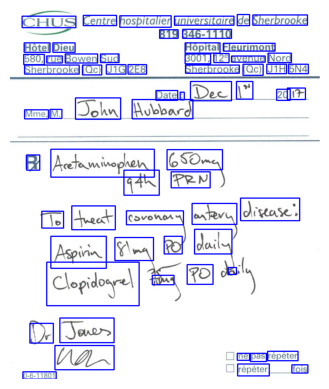

In [15]:
# Uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
!pip uninstall -y tensorflow
# Install doctr
!pip install python-doctr[torch,viz]@git+https://github.com/mindee/doctr.git

# Imports
import os
import tempfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores

# Helper function to convert relative coordinates to absolute pixel values
def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
    h, w = img_shape
    if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
        (xmin, ymin), (xmax, ymax) = geom
        xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
        ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
        return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    else:  # For polygons, convert each point to absolute coordinates
        return [[int(point[0] * w), int(point[1] * h)] for point in geom]

# Upload an image from the local directory
uploaded_files = files.upload()

# Assuming you uploaded one image, get its filename
uploaded_filename = list(uploaded_files.keys())[0]

# Read the uploaded image
receipt_image = cv2.imdecode(np.frombuffer(uploaded_files[uploaded_filename], np.uint8), cv2.IMREAD_COLOR)

# Save the uploaded image to a temporary file
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
    temp_filename = temp_file.name
    cv2.imwrite(temp_filename, receipt_image)

# Create a folder named after the image file (without the extension)
base_filename = os.path.splitext(uploaded_filename)[0]
output_folder = base_filename  # you can change this as needed
os.makedirs(output_folder, exist_ok=True)

# Define the detection predictor
det_predictor = detection_predictor(
    arch="db_resnet50",
    pretrained=True,
    assume_straight_pages=True,
    symmetric_pad=True,
    preserve_aspect_ratio=True,
    batch_size=1,
)  # .cuda().half()  # Uncomment this line if you have a GPU

# Define the postprocessing parameters (optional)
det_predictor.model.postprocessor.bin_thresh = 0.3
det_predictor.model.postprocessor.box_thresh = 0.1

# Load the document image from the temporary file
docs = DocumentFile.from_images([temp_filename])
results = det_predictor(docs)

# Initialize a counter for naming cropped word images
word_index = 0

# Loop over each document and its detection results
for doc, res in zip(docs, results):
    img_shape = (doc.shape[0], doc.shape[1])
    # Detach the probability scores from the results
    detached_coords, prob_scores = detach_scores([res.get("words")])

    for coords in detached_coords[0]:
        # If the coordinates are given as a flat array of 4 numbers, reshape them to 2 points
        coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

        # Convert relative to absolute pixel coordinates
        points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))

        # Draw the bounding box on the image (optional, for visualization)
        cv2.polylines(receipt_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

        # Compute an axis-aligned bounding rectangle for the detected word
        x, y, w, h = cv2.boundingRect(points)

        # Crop the word region from the image
        cropped_word = receipt_image[y:y+h, x:x+w]

        # Build the path to save the cropped word image
        save_path = os.path.join(output_folder, f'word_{word_index}.png')

        # Save the cropped image
        cv2.imwrite(save_path, cropped_word)

        word_index += 1

# Display the image with bounding boxes (for visualization)
%matplotlib inline
plt.imshow(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [16]:
def predict_and_save_results(image_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all files in the image folder
    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):  # Handle image formats
            image_path = os.path.join(image_folder, image_file)

            # Predict text for the image
            predicted_text = predict_image(image_path)

            # Create the output .txt file path
            txt_file_name = os.path.splitext(image_file)[0] + ".txt"  # Same name as image but with .txt extension
            txt_file_path = os.path.join(output_folder, txt_file_name)

            # Save the predicted text to the file
            with open(txt_file_path, 'w') as f:
                f.write(predicted_text)

            print(f"Saved predicted text for {image_file} to {txt_file_path}")

# Specify the input folder containing images and the output folder for text files
image_folder = '/content/94/'  # Folder containing the images
output_folder = '/content/doctor1/'  # Folder to save the predicted text files
# Predict and save results for all images in the folder
predict_and_save_results(image_folder, output_folder)

print("All predictions saved.")


Saved predicted text for word_22.png to /content/doctor1/word_22.txt
Saved predicted text for word_52.png to /content/doctor1/word_52.txt
Saved predicted text for word_45.png to /content/doctor1/word_45.txt
Saved predicted text for word_44.png to /content/doctor1/word_44.txt
Saved predicted text for word_63.png to /content/doctor1/word_63.txt
Saved predicted text for word_49.png to /content/doctor1/word_49.txt
Saved predicted text for word_2.png to /content/doctor1/word_2.txt
Saved predicted text for word_26.png to /content/doctor1/word_26.txt
Saved predicted text for word_55.png to /content/doctor1/word_55.txt
Saved predicted text for word_19.png to /content/doctor1/word_19.txt
Saved predicted text for word_56.png to /content/doctor1/word_56.txt
Saved predicted text for word_13.png to /content/doctor1/word_13.txt
Saved predicted text for word_64.png to /content/doctor1/word_64.txt
Saved predicted text for word_0.png to /content/doctor1/word_0.txt
Saved predicted text for word_29.png t